In [1]:
!nvidia-smi

Sun Sep  3 17:46:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Setup

In [2]:
!pip install -q -U sentence-transformers
!pip install -q -U google-cloud-bigquery
!pip install -q -U tqdm
!pip install cudf-cu11 cuml-cu11 --extra-index-url=https://pypi.nvidia.com

### Librerias

In [30]:
import torch

from cuml import DBSCAN, TSNE

from google.cloud.bigquery import Client
from google.oauth2.service_account import Credentials

from sentence_transformers import SentenceTransformer

from tqdm import tqdm

import matplotlib.pyplot as plt

### Variables

In [4]:
SERVICE_ACC_FILE="/content/valid-dragon-397303-a396a9a99124.json"
PROJECT_ID="valid-dragon-397303"
SEED=1399

In [5]:
CREDENTIALS = Credentials.from_service_account_file(SERVICE_ACC_FILE)
client = Client(project=PROJECT_ID, credentials=CREDENTIALS)

### Dataset

Como el dataset original tiene mas de 130 millones de reviews, para esta primera entrega se utilizaran unicamente los datos relacionados a la categoria de videojuegos.

In [6]:
# Se traen los datos desde BigQuery
QUERY = (
    "SELECT * "
    "FROM `valid-dragon-397303.amazon_reviews.modeling_data` "
    "WHERE first_category_item = 'Video Games';"
)
job = client.query(QUERY)
data = job.to_arrow()

### Inspeccionar el dataset

In [7]:
# Se verifica el tipo de objeto
type(data)

pyarrow.lib.Table

In [8]:
# Se verifica el esquema de los datos
data.schema

review: string
brand: string
first_category_item: string

In [9]:
# Se verifica la estructura de los datos
data.shape

(1722888, 3)

- El conjunto de datos tiene 1.722.888 filas, de las cuales, cada una corresponde a un review diferente a un objeto dentro de la categoria de video juegos de Amazon.
- El conjunto de datos tiene 3 columnas: `review` que corresponde al review del objeto, `brand` que corresponde a la marca del objeto y `first_category_item` que corresponde a la categoria del objeto.

In [10]:
# Se visualizan las primeras 5 filas
data.slice(0, 5)

pyarrow.Table
review: string
brand: string
first_category_item: string
----
review: [["The first foray for a baseball game carrying the MLB license on the DS is here with Major League Baseball 2K7, and it should have either spent much more time in development or just should have never been made period.  The first thing you'll notice is the lack of options when you first turn on the game.  You'd think a sports game in this day and age would include a season mode, not to mention the ability to trade and release players, sign free agents, and a create a player option too.  Well, you get none of that here.  Instead, you get to jump into the playoffs, play an exhibition game, and play Home Run Derby.  These missing features wouldn't be so bad if the game itself wasn't so annoying to look at, let alone play.  Graphically speaking, the DS can pump out some decent looking 3-D graphics that while not perfect, show off what the system can do.  MLB 2K7 looks like it just jumped off the Genesis wh

### Obtener embeddings de las reviews

Con el fin de utilizar las reviews como input de los algoritmos no supervisados, se necesita obtener una representacion numerica (embeddings) de los textos. Para esto utilizaremos el modelo `all-mpnet-base-v2`

In [11]:
# Se carga el modelo
MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
model = SentenceTransformer(MODEL_NAME, device="cuda")

In [12]:
# Se crea un tensor lleno de ceros para almacenar los embeddings
EMBEDDINGS_DIMENSION = 768
N = data.shape[0]
embeddings = torch.zeros((N, EMBEDDINGS_DIMENSION), device="cuda")

In [13]:
%%time
# Se obtienen los embeddings
start_idx = 0

# Se itera sobre los chunks de los reviews
for chunk in tqdm(data["review"].iterchunks(), total=data["review"].num_chunks):
    chunk_list = chunk.to_pylist()
    end_idx = start_idx + len(chunk_list)

    # Se obtienen los embeddings y se guardan en la GPU
    embeddings_chunk = model.encode(
        sentences=chunk_list,
        batch_size=120,
        device="cuda",
        convert_to_tensor=True
    ).to("cuda")

    # Se guardan los embeddings en el tensor creado anteriormente
    embeddings[start_idx:end_idx, :] = embeddings_chunk
    start_idx = end_idx

100%|██████████| 432/432 [44:52<00:00,  6.23s/it]

CPU times: user 1h 5min 59s, sys: 44.7 s, total: 1h 6min 44s
Wall time: 44min 52s


In [16]:
embeddings.shape

torch.Size([1722888, 768])

In [17]:
type(embeddings[0])

torch.Tensor

### Reduccion de dimensionalidad

In [25]:
model = TSNE(n_components=2, random_state=SEED, method="fft", perplexity=50, n_neighbors=50*3)
truncated_embeddings = model.fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [18:46:05.193026] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


#### Visualizamos los embeddings

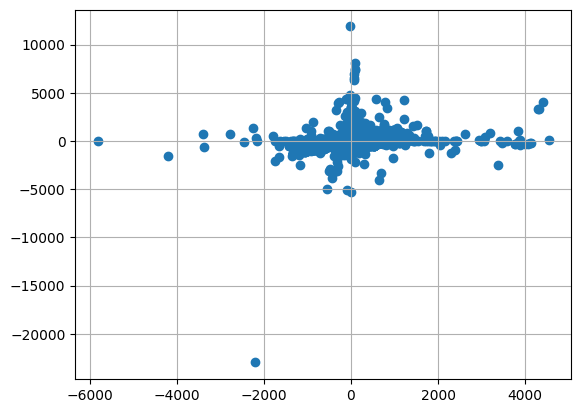

In [26]:
plt.scatter(x=truncated_embeddings[:, 0].get(), y=truncated_embeddings[:, 1].get())
plt.grid()

### Clusters

In [32]:
cluster = DBSCAN()
cluster.fit(truncated_embeddings)

[W] [19:13:42.901764] Batch size limited by the chosen integer type (4 bytes). 3942 -> 1246. Using the larger integer type might result in better performance


DBSCAN()

In [33]:
cluster_labels = cluster.predict(truncated_embeddings)

AttributeError: ignored